# Distillation Setup
Using pytorch to construct distillation.
Like the paper, we focus only on the peformance matching method of dataset
distillation for the proposed QNN mode.

- We have a model (classical LeNet or Quantum LeNet)
- We have a real training Dataset $x$ (MNIST or CIFAR-10)
- We want to learn a tiny synthetic dataset $\tilde{x}$ such that:

  Training the model on $\tilde{x}$ for a few GD steps from a fixed initialization gives almost the same test accuracy as training on the full real dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

try:
   import pennylane as qml
except ImportError:
  !pip install pennylane
  import pennylane as qml

import matplotlib.pyplot as plt
import numpy as np

from torch.func import functional_call

## Load Dataset (MNIST)

In [ ]:
# MNIST images are typically grayscale and need to be converted to PyTorch tensors. Normalization is also a common practice.
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Standard Mean and std for MNIST
    ])

In [ ]:
training_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


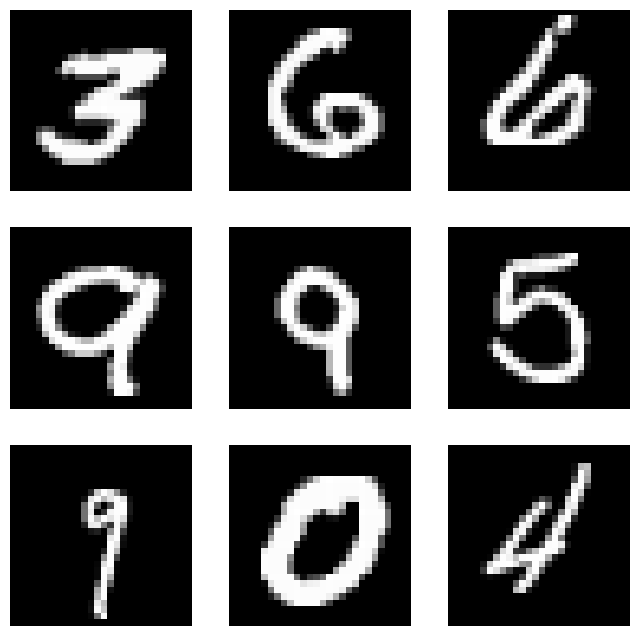

In [ ]:
# Show sample of the MNIST dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# While training a model, we typically want to pass samples in “minibatches”.
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


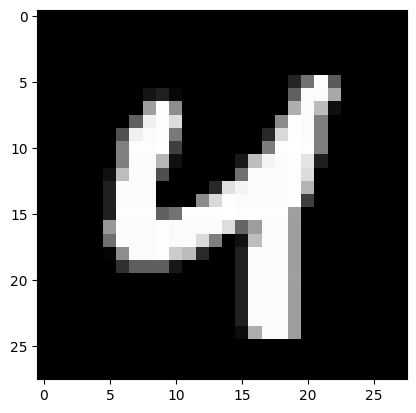

Label: 4


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Define the CNN

This is copied CNN initialization

TODO: To be replaced with Kjell and Kris work

In [ ]:
def init_random_hermitian_observable(n_qubits):
  Hermitian = torch.randn(n_qubits, 4)
  return Hermitian

### Actual Quantum Layer
n_qubits = 6 #2^6 = 64, so will embed the length 64 vector
entangling_layers = 3 # The PQC strongly entangling layers happens 3 times.
fixed_hermitians = True

dev = qml.device("default.qubit", wires=n_qubits)
I = torch.tensor([[1,0],[0,1]])
X = torch.tensor([[0,1],[1,0]])
Y = torch.tensor([[0,-1j],[1j,0]])
Z = torch.tensor([[1,0],[0,-1]])

# Define Quantum Circuit and Link with PyTorch
@qml.qnode(dev, interface='torch')
def qnn_circuit(inputs, weights, hermitians):
  # Amplitude Embedding
  qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)

  # Strong Entangling Layers
  qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

  # Measure Hermitian Observable

  expvals = []

  for q in range(n_qubits):
    ai, ax, ay, az = hermitians[q]
    observable = (ai*I) + (ax*X) + (ay*Y) + (az*Z)

    expvals.append(qml.expval(qml.Hermitian(observable, q)))

  return expvals

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class QuantumLeNet(nn.Module):
    def __init__(self, alpha=0.5, fixed_hermitians=True, residual_connection=True):
        super(QuantumLeNet, self).__init__()

        ### Convolution 1
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        ### Pooling 1
        self.p1 = nn.AvgPool2d(kernel_size=2, stride=2)
        ### Convolution 2
        self.c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        ### Pooling 2
        self.p2 = nn.AvgPool2d(kernel_size=1, stride=1)
        ### Full Connections
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=16*10*10, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=64)

        ### Residual Full Connection Layer (Classical Output)
        self.rfc = nn.Linear(in_features=64, out_features=10)

        if(residual_connection=True):
          self.alpha = alpha
        else:
          self.alpha = 1

        # Quantum Layer
        weight_shapes = {
            "weights":(entangling_layers, n_qubits, 3),
            "hermitians":(n_qubits, 4)
        }

        # Creates the quantum layer
        self.qnn_layer = qml.qnn.TorchLayer(qnn_circuit, weight_shapes)

        #Initialize Hermitians randomly
        with torch.no_grad():
            hermitian_init = init_random_hermitian_observable(n_qubits)
            self.qnn_layer.hermitians.copy_(hermitian_init)

        if(fixed_hermitians):
          self.qnn_layer.hermitians.requires_grad = False
        else:
          self.qnn_layer.hermitians.requires_grad = True

        self.qnn_final = nn.Linear(in_features=6, out_features=10)

    def forward(self, x):
      x1 = self.c1(x)
      # print("C1 Shape:", x1.shape)

      p1 = self.p1(x1)
      # print("P1 Shape:", p1.shape)

      x2 = self.c2(p1)
      # print("C2 Shape:", x2.shape)

      p2 = self.p2(x2)
      # print("P2 Shape:", p2.shape)

      flatten = self.flatten(p2)

      x3 = self.fc1(flatten)
      # print("FC1 Shape:", x3.shape)
      x4 = self.fc2(x3)
      # print("FC2 Shape:", x4.shape)

      # Classical Output
      rfc_out = self.rfc(x4)

      # Quantum Output
      qnn_out = self.qnn_layer(x4)
      qnn_final = self.qnn_final(qnn_out)

      # Combination
      out = (rfc_out * (1 - self.alpha)) + (qnn_final * self.alpha)

      return out

model = QuantumLeNet().to(device)
print(model)

Using cpu device
QuantumLeNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (p1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (p2): AvgPool2d(kernel_size=1, stride=1, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (rfc): Linear(in_features=64, out_features=10, bias=True)
  (qnn_layer): <Quantum Torch Layer: func=qnn_circuit>
  (qnn_final): Linear(in_features=6, out_features=10, bias=True)
)


In [ ]:
# To train a model we need a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# Single training loop, the model makes predictions on the training dataset (fed to it in batches)
# and backpropagates the prediction error to adjust the model’s parameters
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Check model performance on full MNIST Dataset

In [ ]:
# Check the model’s performance against the test dataset
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.382247  [   64/60000]
loss: 2.244465  [ 6464/60000]
loss: 2.220125  [12864/60000]
loss: 2.172464  [19264/60000]
loss: 2.116586  [25664/60000]
loss: 2.017250  [32064/60000]
loss: 2.015524  [38464/60000]
loss: 1.987009  [44864/60000]
loss: 1.930768  [51264/60000]
loss: 1.917993  [57664/60000]
Test Error: 
 Accuracy: 60.9%, Avg loss: 1.931172 

Epoch 2
-------------------------------
loss: 1.974500  [   64/60000]
loss: 1.948904  [ 6464/60000]
loss: 1.935351  [12864/60000]
loss: 1.796359  [19264/60000]
loss: 1.750262  [25664/60000]
loss: 1.623058  [32064/60000]
loss: 1.579317  [38464/60000]
loss: 1.452662  [44864/60000]
loss: 1.263927  [51264/60000]
loss: 1.094786  [57664/60000]
Test Error: 
 Accuracy: 80.4%, Avg loss: 1.079122 

Done!


In [ ]:
# Save the model
torch.save(model.state_dict(), "test_model.pth")
print("Saved PyTorch Test Model State to test_model.pth")

Saved PyTorch Test Model State to test_model.pth


In [ ]:
# Load the model
test_model = QuantumLeNet().to(device)
test_model.load_state_dict(torch.load("test_model.pth"))

<All keys matched successfully>

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
test_model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.unsqueeze(0).to(device) # TODO: Check if unsqueeze has the correct impact.
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"


In [ ]:
def evaluate_model(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Move data to the same device as the model
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest Set Metrics:')
    print(f'  Average Loss: {test_loss:.4f}')
    print(f'  Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    return accuracy

In [ ]:
evaluate_model(test_model, device, test_dataloader)


Test Set Metrics:
  Average Loss: -1.6029
  Accuracy: 8040/10000 (80.40%)


80.4

# Distillation Algorithm


Taken from https://github.com/ssnl/dataset-distillation/blob/master/train_distilled_image.py with adjustments to single model

- Initialize synthetic images from random noise (10 images for MNIST, 1 per class)
- Learn both the synthetic data AND the learning rate
- For each iteration:
  - Reset model to fixed initialization
  - Train on synthetic data for a few steps
  - Evaluate on real training batch
  - Backpropagate to update synthetic images

In [ ]:
from torch.func import functional_call
import torch.nn.functional as F
import torch

def distill_dataset(
    model_class,
    train_loader,
    test_loader,
    device,
    num_classes=10,
    images_per_class=1,
    gradient_descent_steps=1, #step per epoch
    distill_epochs=3, #epochs
    distill_lr=0.01,
    num_distill_iters=1000, #how many outer loops
    log_interval=100, # interval in which we log (just for display)
):
    """
    Distill a dataset into a small set of synthetic images.
    """

    num_classes = num_classes

    # Learnable synthetic images
    synthetic_data = torch.randn(
        num_classes * images_per_class, 1, 28, 28,
        device=device, requires_grad=True #grad enables the parameters to be trainable
    )
    synthetic_labels = torch.arange(num_classes, device=device).repeat_interleave(images_per_class)

    # Learnable log learning rate (log to ensure positivity)
    log_lr = torch.tensor(distill_lr, device=device).log().requires_grad_(True)

    # Optimizer over synthetic images + log_lr
    optimizer = torch.optim.Adam([synthetic_data, log_lr], lr=0.01)

    # Base model and its initial parameters / state_dict
    base_model = model_class().to(device)
    initial_state_dict = base_model.state_dict()  # stores the initial weights of the model
    initial_params = { # clone of all parameters to be used in the optimization loop
        name: p.detach().clone()
        for name, p in base_model.named_parameters()
    }

    train_iter = iter(train_loader) # do this to get batches one by one (we might loop through the entire dataset more than once)

    print(f"Starting distillation with {num_classes * images_per_class} synthetic images...")
    print(f"Distill steps: {gradient_descent_steps}, Distill epochs: {distill_epochs}")

    for iteration in range(num_distill_iters):
        optimizer.zero_grad()

        # Get a real batch
        try:
            real_data, real_labels = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            real_data, real_labels = next(train_iter)

        real_data, real_labels = real_data.to(device), real_labels.to(device)

        # Reset inner-loop params from initial_params (and make them require grad)
        params = {
            name: p.clone().detach().requires_grad_(True)
            for name, p in initial_params.items()
        }

        current_lr = log_lr.exp()

        # ----- Inner loop: train on synthetic data -----
        for epoch in range(distill_epochs):
          for step in range(gradient_descent_steps):
            # forward pass on synthetic data using current params
            new_synthetic_labels = functional_call(base_model, params, (synthetic_data,))

            # compute inner loss on synthetic data
            inner_loss = F.cross_entropy(new_synthetic_labels, synthetic_labels)

            # compute gradients of inner loss w.r.t. current params
            grads = torch.autograd.grad(
              inner_loss,
              list(params.values()),
              create_graph=True
            )

            # gradient descent update on the parameter dictionary
            params = {
              name: param - current_lr * grad
              for (name, param), grad in zip(params.items(), grads)
            }
        # ----- End of inner loop: train on synthetic data -----

        # evaluate updated params on real data
        real_new_labels = functional_call(base_model, params, (real_data,))
        outer_loss = F.cross_entropy(real_new_labels, real_labels)

        # Backprop to synthetic_data and log_lr
        outer_loss.backward()
        optimizer.step()

        # ----- Logging / evaluation -----
        if iteration % log_interval == 0 or iteration == num_distill_iters - 1:
            # Detach current synthetic data and lr for evaluation so it doesn't
            # extend the main graph
            syn_eval = synthetic_data.detach()
            syn_labels_eval = synthetic_labels.detach()
            lr_eval = float(current_lr.detach().cpu())

            # Fresh model for evaluation: train on synthetic images with normal SGD
            eval_model = model_class().to(device)
            eval_model.load_state_dict(initial_state_dict)
            eval_model.train()
            eval_opt = torch.optim.SGD(eval_model.parameters(), lr=lr_eval)

            total_steps = gradient_descent_steps * distill_epochs #added this
            for _ in range(total_steps):
                out = eval_model(syn_eval)
                loss = F.cross_entropy(out, syn_labels_eval)
                eval_opt.zero_grad()
                loss.backward()
                eval_opt.step()

            # Test accuracy
            eval_model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    out = eval_model(data)
                    pred = out.argmax(dim=1)
                    correct += (pred == target).sum().item()
                    total += target.size(0)

            acc = 100.0 * correct / total
            print(
                f"Iter {iteration:4d} | "
                f"Outer Loss: {outer_loss.item():.4f} | "
                f"LR: {current_lr.item():.5f} | "
                f"Test Acc: {acc:.2f}%"
            )

    return synthetic_data.detach(), synthetic_labels, log_lr.exp().detach()


In [ ]:
print("\n" + "="*60)
print("DISTILLING MNIST DATASET")
print("="*60 + "\n")

synthetic_data, synthetic_labels, learned_lr = distill_dataset(
    model_class=QuantumLeNet,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=device,
    num_classes=10,
    images_per_class=1,      # 1 image per class = 10 total images
    gradient_descent_steps=1,          # Paper uses 1 step for MNIST
    distill_epochs=3,         # Paper uses 3 epochs for MNIST
    distill_lr=0.01,         # Initial learning rate
    num_distill_iters=500,  # Number of distillation iterations
    log_interval=100
)

print(f"\nDistillation complete!")
print(f"Learned LR: {learned_lr.item():.6f}")
print(f"Synthetic data shape: {synthetic_data.shape}")


DISTILLING MNIST DATASET

Starting distillation with 10 synthetic images...
Distill steps: 1, Distill epochs: 3


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
def visualize_distilled_images(images, labels):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for idx, (img, label) in enumerate(zip(images, labels)):
        # Denormalize for visualization
        img_show = img.cpu().squeeze() * 0.3081 + 0.1307
        img_show = torch.clamp(img_show, 0, 1)

        axes[idx].imshow(img_show, cmap='gray')
        axes[idx].set_title(f'Class {label.item()}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('distilled_mnist.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved visualization to 'distilled_mnist.png'")

visualize_distilled_images(synthetic_data, synthetic_labels)

In [ ]:
print("\n" + "="*60)
print("TESTING: Paper-style training (few steps) on distilled data")
print("="*60 + "\n")

test_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(test_model.parameters(), lr=learned_lr.item())

total_steps = 3   # gradient_descent_steps * distill_epochs = 1 * 3

for step in range(total_steps):
    test_model.train()
    optimizer.zero_grad()
    output = test_model(synthetic_data)
    loss = F.cross_entropy(output, synthetic_labels)
    loss.backward()
    optimizer.step()
    print(f"Step {step}: Loss = {loss.item():.4f}")

# Evaluate on test set
test_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = test_model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

final_accuracy = 100.0 * correct / total
print(f"\nFinal test accuracy (paper-style): {final_accuracy:.2f}%")
